In [1]:
import time

import torch
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
)

import load_dataset
from load_dataset import add_label_id
from models import T5EncoderClassifier

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
device = "mps"
model = torch.load("./t5_results/transformer/model/model.pt", map_location=device)

Using device: cpu


In [13]:
simplified_labels = [
    "Web",
    "International",
    "Etat",
    "Wirtschaft",
    "Panorama",
    "Sport",
    "Wissenschaft",
    "Kultur",
    "Heimat",
]
decoder_attentionmask = [1 for _ in range(len(load_dataset.label_to_id))]
decoder_inputs = [
    model.tokenizer(simplified_label).input_ids[0]
    for simplified_label in simplified_labels
]


def tokenize_function(examples):
    if model.is_transformer:
        input_tokenized = model.tokenizer(
            examples["text"], padding="max_length", max_length=512, truncation=True
        )
        return {
            "input_ids": input_tokenized.input_ids,
            "input_attention_mask": input_tokenized.attention_mask,
            "decoder_ids": decoder_inputs,
            "decoder_attention_mask": decoder_attentionmask,
        }
    else:
        if type(model) == T5EncoderClassifier:
            return model.tokenizer(
                examples["text"], padding="max_length", max_length=512, truncation=True
            )
        else:
            return model.tokenizer(
                examples["text"], padding="max_length", truncation=True
            )

In [14]:
_, test_ds = load_dataset.load_dataset(
    "../German_newspaper_articles/10kGNAD/train.csv",
    "../German_newspaper_articles/10kGNAD/test.csv",
)

In [15]:
test_ds = test_ds.map(tokenize_function)

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [16]:
test_ds = test_ds.map(add_label_id)

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [17]:
y_true = []
y_pred = []
wrong = []


def test():
    model.eval()
    test_ds.set_format("torch", device=device)
    start_time = time.perf_counter()
    for data in test_ds:
        label_id = torch.unsqueeze(data["label_id"], 0)
        if model.is_transformer:
            output = model(
                torch.unsqueeze(data["input_ids"], 0),
                torch.unsqueeze(data["input_attention_mask"], 0),
                torch.unsqueeze(data["decoder_ids"], 0),
                torch.unsqueeze(data["decoder_attention_mask"], 0),
            )
        else:
            output = model(
                torch.unsqueeze(data["input_ids"], 0),
                torch.unsqueeze(data["attention_mask"], 0),
            )
        output = torch.argmax(output)
        global y_true
        global y_pred
        y_true.append(load_dataset.id_to_label[label_id.item()])
        y_pred.append(load_dataset.id_to_label[output.item()])

        if label_id.item() is not output.item():
            global wrong
            item = {
                "text": data["text"],
                "prediction": load_dataset.id_to_label[output.item()],
                "label": data["label"],
            }
            wrong.append(item)
    end_time = time.perf_counter()
    print(f"Test took {(end_time - start_time)/60:0.4f} minutes")

In [18]:
test()

Test took 1.2296 minutes


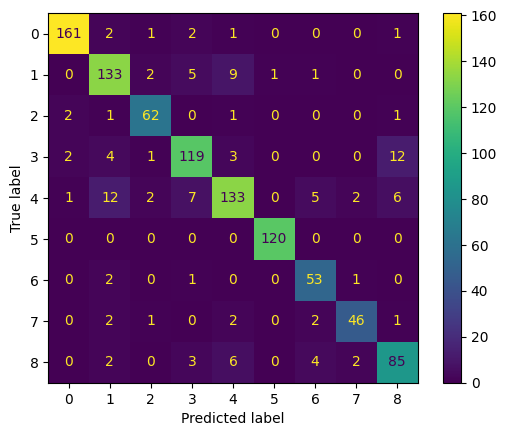

In [19]:
cm = confusion_matrix(
    y_true,
    y_pred,
    labels=[
        "Web",
        "International",
        "Etat",
        "Wirtschaft",
        "Panorama",
        "Sport",
        "Wissenschaft",
        "Kultur",
        "Inland",
    ],
)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [10]:
accuracy_score(y_true, y_pred)

0.9027237354085603

In [11]:
f1_score(y_true, y_pred, average="weighted")

0.9026718406604519